MultiDiGraph with 2165 nodes and 4317 edges
Closest road: Unnamed Road
u           v           key
305809217   516673953   0       LINESTRING (11.2916 60.65734, 11.29128 60.65863)
2786289538  305809220   0      LINESTRING (11.29181 60.65601, 11.29176 60.65646)
516673953   2786289548  0      LINESTRING (11.29128 60.65863, 11.29094 60.66002)
305809220   2786289544  0       LINESTRING (11.29176 60.65646, 11.2917 60.65688)
305809221   2786289534  0      LINESTRING (11.29184 60.65527, 11.29182 60.65569)
Name: geometry, dtype: geometry


/tmp/ipykernel_89603/447716230.py:104: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


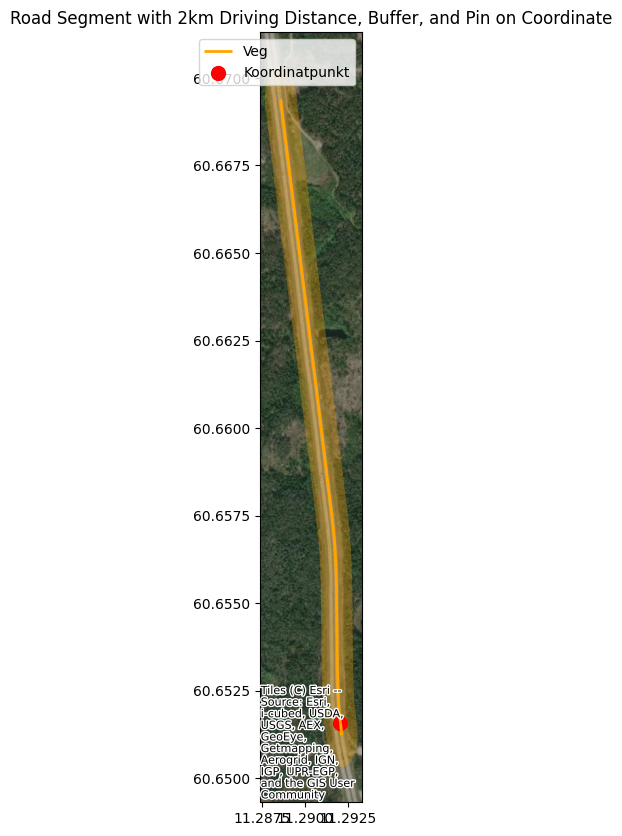

0.0009164212007428091


In [120]:
import osmnx as ox
import networkx as nx
from shapely.geometry import Point, LineString
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import unary_union
import math
import contextily as cx

# Coordinates of the point
lat, lon = 60.6515862, 11.2920685


# Buffer distance in meters
buffer_distance_meters = 50  # 100 meters buffer distance

# Convert the buffer distance from meters to degrees (lat/lon)
def meters_to_degrees(lat, lon, meters):
    """
    Convert distance in meters to degrees for latitude and longitude.
    """
    # Conversion for latitude (1 degree latitude ~ 111,320 meters)
    lat_degrees = meters / 111320

    # Conversion for longitude depends on the latitude (1 degree longitude varies)
    lon_degrees = meters / (111320 * math.cos(math.radians(lat)))
    
    return lat_degrees, lon_degrees

# Convert 100 meters to degrees
lat_buffer, lon_buffer = meters_to_degrees(lat, lon, buffer_distance_meters)

# Load the road network for a 2km radius around the point
custom_filter = '["highway"~".*"]'
G = ox.graph_from_point((lat, lon), dist=2000, simplify=False, network_type='all')
print(G)
# Find the nearest edge (road) to the given point
nearest_edge = ox.distance.nearest_edges(G, X=lon, Y=lat)
u, v, key = nearest_edge  # u, v are nodes; key identifies the edge
road_name = G[u][v][key].get("name", "Unnamed Road")

print(f"Closest road: {road_name}")

# Extract a subgraph containing roads within a given driving distance from the closest road
def get_road_segment_within_driving_distance(G, u, v, max_distance_meters):
    """
    Extract a road segment within a given driving distance (e.g., 2 km in this case).
    This function finds the connected roads up to the max_distance in both directions.

    Args:
        G: NetworkX graph of the road network.
        u, v: Nodes representing the closest edge (road).
        max_distance_meters: Distance to traverse in both directions (in meters).

    Returns:
        A subgraph containing the road segment within the driving distance.
    """
    road_name = G[u][v][key].get("name", "Unnamed Road")
    
    # Create subgraph that includes only roads from the nearest edge
    edges_to_keep = [
        (a, b, k)
        for a, b, k in G.edges(keys=True)
        if G[a][b][k].get("name", "Unnamed Road") == road_name
    ]
    H = G.edge_subgraph(edges_to_keep).copy()

    # Collect nodes that are within the max distance (2 km)
    subgraph_nodes = set()
    for node in [u, v]:
        # Use Dijkstra to find the reachable nodes within the max distance
        for current_node, distance in nx.single_source_dijkstra_path_length(
            H, node, cutoff=max_distance_meters
        ).items():
            subgraph_nodes.add(current_node)

    return H.subgraph(subgraph_nodes).copy()

# Get the road segment (2 km in both directions from the point)
road_segment = get_road_segment_within_driving_distance(G, u, v, max_distance_meters=2000)

# Extract the geometries of the road edges
edges = ox.graph_to_gdfs(road_segment, nodes=False)
print(edges['geometry'].head())
# Buffer the road geometries by the converted degrees
road_lines = unary_union(edges["geometry"])
buffered_polygon = road_lines.buffer(lon_buffer)

# Convert to GeoDataFrame for plotting
buffer_gdf = gpd.GeoDataFrame(geometry=[buffered_polygon], crs=edges.crs)

# Create GeoDataFrame for the pin (the coordinate point)
point_geom = Point(lon, lat)
point_gdf = gpd.GeoDataFrame(geometry=[point_geom], crs=edges.crs)

# Plot the road segment and the buffer, and add a pin for the point
fig, ax = plt.subplots(figsize=(10, 10))
edges.plot(ax=ax, color="orange", linewidth=2, label="Veg")
buffer_gdf.plot(ax=ax, color="orange", alpha=0.3, label="Buffer")
point_gdf.plot(ax=ax, marker="o", color="red", markersize=100, label="Koordinatpunkt")
cx.add_basemap(ax, source=cx.providers.Esri.WorldImagery, crs=edges.crs)

# Add legend, title, and show the plot
plt.legend()
plt.title("Road Segment with 2km Driving Distance, Buffer, and Pin on Coordinate")
plt.show()
print(lon_buffer)

{'version': 0.6, 'generator': 'Overpass API 0.7.62.4 2390de5a', 'osm3s': {'timestamp_osm_base': '2025-01-15T17:18:14Z', 'copyright': 'The data included in this document is from www.openstreetmap.org. The data is made available under ODbL.'}, 'elements': [{'type': 'way', 'id': 2274129, 'bounds': {'minlat': 60.7657829, 'minlon': 11.3055947, 'maxlat': 60.7810035, 'maxlon': 11.3102321}, 'nodes': [156556, 4932032705, 4932032661, 156557, 4932032660, 2876539797, 805863770, 2876539722, 805863775, 2876539546, 156558, 2876539489, 2876539479, 156559, 2876539463, 156560, 715890235, 4299216387, 4299216386, 4299216383, 156562, 4299216382, 4299216381, 156563, 4299216380, 156564, 4299216379, 4299216378, 4299216377, 4299216376, 156565], 'geometry': [{'lat': 60.7810035, 'lon': 11.307176}, {'lat': 60.7807478, 'lon': 11.3071652}, {'lat': 60.7804454, 'lon': 11.3071261}, {'lat': 60.7800433, 'lon': 11.3070344}, {'lat': 60.7797285, 'lon': 11.306927}, {'lat': 60.7794356, 'lon': 11.3067861}, {'lat': 60.7788325,

/tmp/ipykernel_56152/2188451081.py:74: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


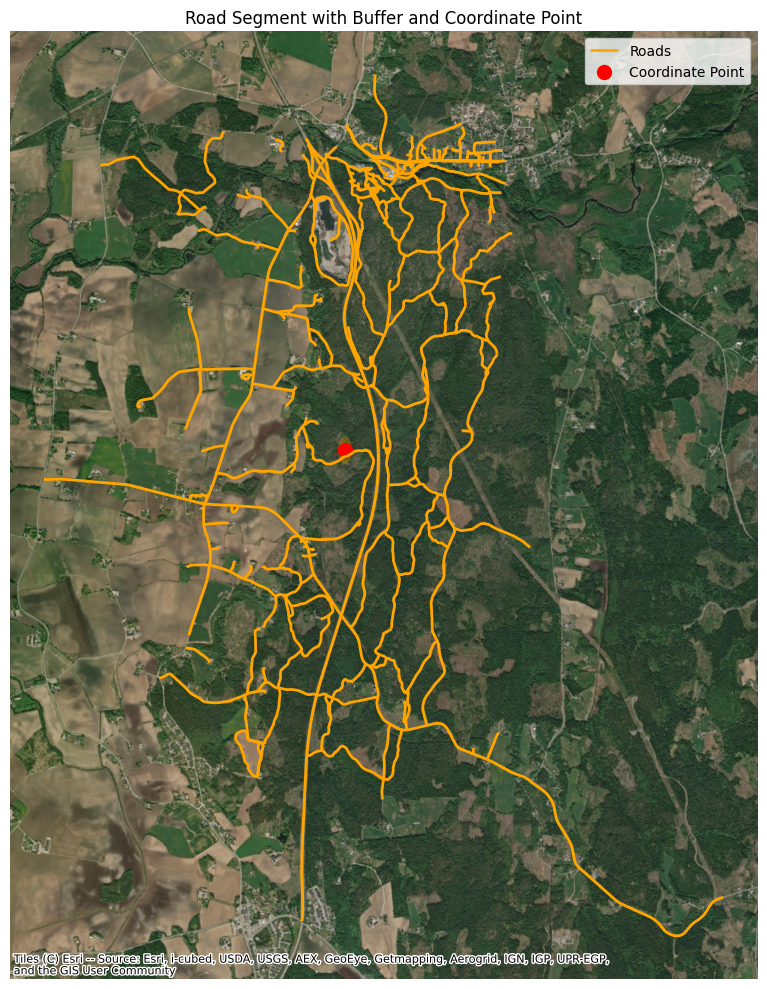

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, box
import contextily as cx
import requests
import json
import math

# Coordinates of the point
lat, lon = 60.768115, 11.305719

# Buffer distance in meters
buffer_distance_meters = 50

# Function to convert meters to degrees
def meters_to_degrees(lat, lon, meters):
    lat_degrees = meters / 111320
    lon_degrees = meters / (111320 * math.cos(math.radians(lat)))
    return lat_degrees, lon_degrees

# Convert buffer distance to degrees
lat_buffer, lon_buffer = meters_to_degrees(lat, lon, buffer_distance_meters)

# Create a bounding box for the Overpass API query
bbox = box(lon - 0.02, lat - 0.02, lon + 0.02, lat + 0.02)

# Overpass API query
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = f"""
[out:json];
(
  way["highway"]({bbox.bounds[1]},{bbox.bounds[0]},{bbox.bounds[3]},{bbox.bounds[2]});
);
out geom;
"""

# Send request to Overpass API
response = requests.get(overpass_url, params={'data': overpass_query})
data = response.json()
# Extract road geometries
roads = []
for element in data['elements']:
    if element['type'] == 'way':
        coords = [(node['lon'], node['lat']) for node in element['geometry']]
        roads.append(LineString(coords))

# Create GeoDataFrame for roads
gdf_roads = gpd.GeoDataFrame(geometry=roads, crs="EPSG:4326")

# Create point and buffer
point = Point(lon, lat)
buffer = point.buffer(lon_buffer)

# Create GeoDataFrames for point and buffer
gdf_point = gpd.GeoDataFrame(geometry=[point], crs="EPSG:4326")
gdf_buffer = gpd.GeoDataFrame(geometry=[buffer], crs="EPSG:4326")

# Transform GeoDataFrames to web Mercator (EPSG:3857)
gdf_roads = gdf_roads.to_crs(epsg=3857)
gdf_buffer = gdf_buffer.to_crs(epsg=3857)
gdf_point = gdf_point.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf_roads.plot(ax=ax, color="orange", linewidth=2, label="Roads")
gdf_buffer.plot(ax=ax, color="orange", alpha=0.3, label="Buffer")
gdf_point.plot(ax=ax, color="red", markersize=100, label="Coordinate Point")

# Add satellite basemap (Esri World Imagery)
cx.add_basemap(ax, source=cx.providers.Esri.WorldImagery, crs=gdf_roads.crs.to_string(), zoom=15)

# Customize plot
plt.legend()
plt.title("Road Segment with Buffer and Coordinate Point")
ax.set_axis_off()
plt.tight_layout()
plt.show()


- - - - -
type
way
- - - - -
id
36806107
- - - - -
bounds
{'minlat': 60.6439899, 'minlon': 11.2504907, 'maxlat': 60.6908216, 'maxlon': 11.2851521}
- - - - -
nodes
[427836232, 9974948726, 427836292, 461982880, 9974948755, 9974948756, 9974948757, 427836293, 9974948808, 9974948807, 9974948806, 427836294, 9974948805, 1489101203, 9974948804, 9974948803, 9974948802, 427836367, 9974948801, 9974948800, 427836368, 9974948799, 427836369, 9974948798, 427836370, 9974948797, 9974948796, 908590733, 1470997856, 2884203758, 9974948785, 9974948784, 427836371, 9974948783, 9974948782, 427836372, 9974948781, 427836373, 9974948780, 427836374, 427836375, 9974948779, 9974948778, 9974948777, 427836376, 9974948776, 9974948775, 427836377, 9974948774, 427836378, 9974948773, 9974948772, 9974948771, 9799419970, 9974948770, 9974948769, 427836379, 9974948768, 9974948767, 427836380, 9974948766, 9974948765, 9799419975, 9974948764, 427836381, 9974948763, 9799419974, 9799419973, 9974948762, 427836382, 9974948761, 997494

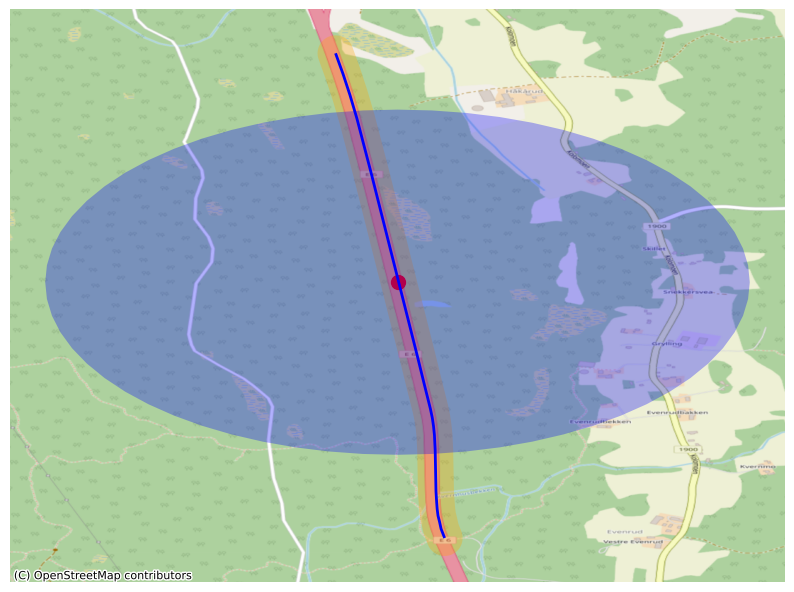

In [110]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, box
import contextily as cx
import requests
import json
import math
from shapely.ops import nearest_points, unary_union
from shapely.geometry import Point

# Coordinates of the point
lat, lon = 60.663811, 11.289924

buffer_distance_meters = 2000

def meters_to_degrees(meters):
    lat_degrees = meters / 111320
    lon_degrees = meters / (111320 * math.cos(math.radians(lat)))
    return lat_degrees, lon_degrees

lat_buffer, lon_buffer = meters_to_degrees(buffer_distance_meters)

lower_lon = lon - lon_buffer
lower_lat = lat - lat_buffer
upper_lon = lon + lon_buffer
upper_lat = lat + lat_buffer
bbox = box(lower_lon, lower_lat, upper_lon, upper_lat)

# Convert buffer distance to degrees

# Overpass API query
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = f"""
[out:json];
(
  way["highway"]({bbox.bounds[1]},{bbox.bounds[0]},{bbox.bounds[3]},{bbox.bounds[2]});
);
out geom;
"""

# Send request to Overpass API
response = requests.get(overpass_url, params={'data': overpass_query})
data = response.json()
for key, value in data['elements'][1].items():
    print('- - - - -')
    print(key)
    print(value)
# Extract road geometries
roads = []
for element in data['elements']:
    if element['type'] == 'way':
        coords = [(node['lon'], node['lat']) for node in element['geometry']]
        roads.append(LineString(coords))

# Create GeoDataFrame for roads
gdf_roads = gpd.GeoDataFrame(geometry=roads, crs="EPSG:4326")

# Create point and GeoDataFrame for the point
point = Point(lon, lat)
gdf_point = gpd.GeoDataFrame(geometry=[point], crs="EPSG:4326")

# Extract the transformed point
point = gdf_point.geometry.iloc[0]

# Find the closest road to the point
closest_road = None
min_distance = float('inf')
closest_road_geometry = None

for road in gdf_roads.geometry:
    # Find nearest point on road to the point
    nearest_geom = nearest_points(point, road)[1]
    distance = point.distance(nearest_geom)
    
    # Update closest road if this one is closer
    if distance < min_distance:
        min_distance = distance
        closest_road = road
        closest_road_geometry = nearest_geom

# Plot the closest road with the buffer
figsize = (10, 10)
fig, ax = plt.subplots(figsize=figsize)

# Plot the closest road
gpd.GeoSeries([closest_road]).plot(ax=ax, color="blue", linewidth=2, label="Closest Road")

# Plot the buffer around the closest road
buffered_closest_road = unary_union(closest_road).buffer(meters_to_degrees(50)[1])
buffer_gdf = gpd.GeoDataFrame(geometry=[buffered_closest_road], crs="EPSG:4326")
buffer_gdf.plot(ax=ax, color="orange", alpha=0.3, label="Buffer", figsize=figsize, aspect="equal")

# # Plot the point
gpd.GeoSeries([point]).plot(ax=ax, color="red", markersize=100, label="Coordinate Point", figsize=figsize, aspect="equal")
gpd.GeoDataFrame(geometry=[gdf_point.to_crs(epsg=3857).geometry.iloc[0].buffer(2000)], crs="EPSG:3857").to_crs(epsg=4326).plot(ax=ax, color="blue", alpha=0.3, label="2000m Radius Circle")

# gpd.GeoSeries([Point(lon - 0.02, lat + 0.02)]).plot(ax=ax, color="white", alpha=0, markersize=100, label="Coordinate Point", figsize=figsize, aspect="equal")
# gpd.GeoSeries([Point(lon + 0.02, lat - 0.02)]).plot(ax=ax, color="white", alpha=0, markersize=100, label="Coordinate Point", figsize=figsize, aspect="equal")
# gpd.GeoSeries([Point(lon - 0.02, lat + 0.02)]).plot(ax=ax, color="white", alpha=0, markersize=100, label="Coordinate Point", figsize=figsize, aspect="equal")
# gpd.GeoSeries([Point(lon + 0.02, lat - 0.02)]).plot(ax=ax, color="white", alpha=0, markersize=100, label="Coordinate Point", figsize=figsize, aspect="equal")

# gpd.GeoSeries([Point(upper_lon, upper_lat)]).plot(ax=ax, color="white", alpha=0.8, markersize=100, label="Coordinate Point", figsize=figsize, aspect="equal")
# gpd.GeoSeries([Point(upper_lon, lower_lat)]).plot(ax=ax, color="white", alpha=0.8, markersize=100, label="Coordinate Point", figsize=figsize, aspect="equal")
# gpd.GeoSeries([Point(lower_lon, upper_lat)]).plot(ax=ax, color="white", alpha=0.8, markersize=100, label="Coordinate Point", figsize=figsize, aspect="equal")
# gpd.GeoSeries([Point(lower_lon, lower_lat)]).plot(ax=ax, color="white", alpha=0.8, markersize=100, label="Coordinate Point", figsize=figsize, aspect="equal")

print(lon_buffer, lat_buffer)
# Add satellite basemap (Esri World Imagery)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, crs=gdf_roads.crs)
ax.axis('off')
ax.set_aspect('equal')
plt.show()

/tmp/ipykernel_89603/134053751.py:85: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


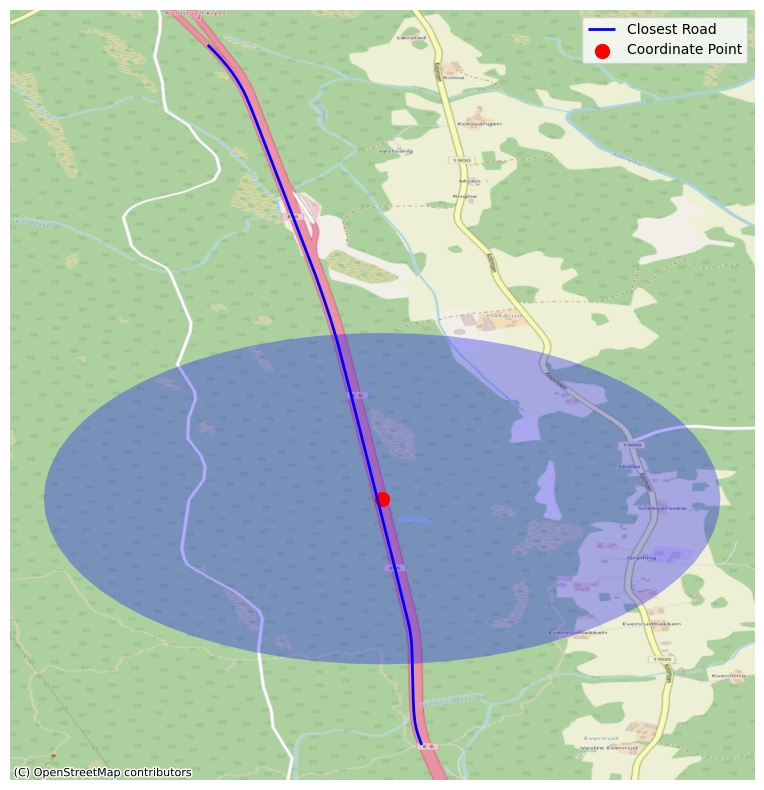

In [99]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, box
import contextily as cx
import requests
import json
import math
from shapely.ops import nearest_points, unary_union
from shapely.geometry import Point

# Coordinates of the point
lat, lon = 60.663811, 11.289924
buffer_distance_meters = 2000

# Function to convert meters to degrees
def meters_to_degrees(meters):
    lat_degrees = meters / 111320  # Approximate degrees per meter for lat
    lon_degrees = meters / (111320 * math.cos(math.radians(lat)))  # Adjust lon for latitude
    return lat_degrees, lon_degrees

# Create the buffer in degrees
lat_buffer, lon_buffer = meters_to_degrees(buffer_distance_meters)

lower_lon = lon - lon_buffer
lower_lat = lat - lat_buffer
upper_lon = lon + lon_buffer
upper_lat = lat + lat_buffer
bbox = box(lower_lon, lower_lat, upper_lon, upper_lat)

# Overpass API query to fetch roads around the buffer area
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = f"""
[out:json];
(
  way["highway"]({bbox.bounds[1]},{bbox.bounds[0]},{bbox.bounds[3]},{bbox.bounds[2]});
);
out geom;
"""

# Send request to Overpass API
response = requests.get(overpass_url, params={'data': overpass_query})
data = response.json()

# Extract road geometries
roads = []
for element in data['elements']:
    if element['type'] == 'way':
        coords = [(node['lon'], node['lat']) for node in element['geometry']]
        roads.append(LineString(coords))

# Create GeoDataFrame for roads
gdf_roads = gpd.GeoDataFrame(geometry=roads, crs="EPSG:4326")

# Create point and GeoDataFrame for the point
point = Point(lon, lat)
gdf_point = gpd.GeoDataFrame(geometry=[point], crs="EPSG:4326")

# Convert to a projected CRS (EPSG:3857) for buffering in meters
gdf_point_projected = gdf_point.to_crs(epsg=3857)

# Buffer the point by 2000 meters
buffered_circle = gdf_point_projected.geometry.iloc[0].buffer(buffer_distance_meters)

# Convert back to EPSG:4326 for plotting in geographic coordinates
gdf_buffer = gpd.GeoDataFrame(geometry=[buffered_circle], crs="EPSG:3857").to_crs(epsg=4326)

# Plotting setup
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the closest road (assuming closest road calculation was done before)
gpd.GeoSeries([gdf_roads.geometry.iloc[0]]).plot(ax=ax, color="blue", linewidth=2, label="Closest Road")

# Plot the buffer circle around the point
gdf_buffer.plot(ax=ax, color="blue", alpha=0.3, label="2000m Radius Circle")

# Plot the point itself
gdf_point.plot(ax=ax, color="red", markersize=100, label="Coordinate Point")

# Add satellite basemap (Esri World Imagery)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, crs=gdf_roads.crs)

# Additional plot settings
ax.set_aspect('equal')
ax.axis('off')
plt.legend()
plt.show()


In [ ]:
import osmnx as ox
import networkx as nx
from shapely.geometry import Point, LineString
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import unary_union, Polygon
import math
import contextily as cx

# Coordinates of the point
lat, lon = 60.6515862, 11.2920685

# Convert the buffer distance from meters to degrees (lat/lon)
def meters_to_degrees(meters):
    """
    Convert distance in meters to degrees for latitude and longitude.
    """
    # Conversion for latitude (1 degree latitude ~ 111,320 meters)
    lat_degrees = meters / 111320

    # Conversion for longitude depends on the latitude (1 degree longitude varies)
    lon_degrees = meters / (111320 * math.cos(math.radians(lat)))
    
    return lat_degrees, lon_degrees

lat_buffer, lon_buffer = meters_to_degrees(2000)

# Calculate the 4 corners of the rectangle (buffered area)
lower_lon = lon - lon_buffer
lower_lat = lat - lat_buffer
upper_lon = lon + lon_buffer
upper_lat = lat + lat_buffer

# Create the polygon (rectangle)
polygon_coords = [
    (lower_lon, lower_lat),
    (upper_lon, lower_lat),
    (upper_lon, upper_lat),
    (lower_lon, upper_lat),
    (lower_lon, lower_lat),  # Close the loop
]

polygon = Polygon(polygon_coords)
custom_filter = '["highway"~".*"]'
G = ox.graph_from_polygon(polygon=polygon, retain_all=True, network_type='all', simplify=False, truncate_by_edge=True)
print(G)
# Find the nearest edge (road) to the given point
nearest_edge = ox.distance.nearest_edges(G, X=lon, Y=lat)
u, v, key = nearest_edge  # u, v are nodes; key identifies the edge
road_name = G[u][v][key].get("name", "Unnamed Road")

print(f"Closest road: {road_name}")

# Extract a subgraph containing roads within a given driving distance from the closest road
def get_road_segment_within_driving_distance(G, u, v, max_distance_meters):
    """
    Extract a road segment within a given driving distance (e.g., 2 km in this case).
    This function finds the connected roads up to the max_distance in both directions.

    Args:
        G: NetworkX graph of the road network.
        u, v: Nodes representing the closest edge (road).
        max_distance_meters: Distance to traverse in both directions (in meters).

    Returns:
        A subgraph containing the road segment within the driving distance.
    """
    road_name = G[u][v][key].get("name", "Unnamed Road")
    
    # Create subgraph that includes only roads from the nearest edge
    edges_to_keep = [
        (a, b, k)
        for a, b, k in G.edges(keys=True)
        if G[a][b][k].get("name", "Unnamed Road") == road_name
    ]
    H = G.edge_subgraph(edges_to_keep).copy()

    # Collect nodes that are within the max distance (2 km)
    subgraph_nodes = set()
    for node in [u, v]:
        # Use Dijkstra to find the reachable nodes within the max distance
        for current_node, distance in nx.single_source_dijkstra_path_length(
            H, node, cutoff=max_distance_meters
        ).items():
            subgraph_nodes.add(current_node)

    return H.subgraph(subgraph_nodes).copy()

# Get the road segment (2 km in both directions from the point)
road_segment = get_road_segment_within_driving_distance(G, u, v, max_distance_meters=2000)

# Extract the geometries of the road edges
edges = ox.graph_to_gdfs(road_segment, nodes=False)
print(edges['geometry'].head())
# Buffer the road geometries by the converted degrees
road_lines = unary_union(edges["geometry"])
buffered_polygon = road_lines.buffer(meters_to_degrees(50)[1])

# Convert to GeoDataFrame for plotting
buffer_gdf = gpd.GeoDataFrame(geometry=[buffered_polygon], crs=edges.crs)

# Create GeoDataFrame for the pin (the coordinate point)
point_geom = Point(lon, lat)
point_gdf = gpd.GeoDataFrame(geometry=[point_geom], crs=edges.crs)

# Plot the road segment and the buffer, and add a pin for the point
fig, ax = plt.subplots(figsize=(10, 10))
edges.plot(ax=ax, color="orange", linewidth=2, label="Veg")
buffer_gdf.plot(ax=ax, color="orange", alpha=0.3, label="Buffer")
point_gdf.plot(ax=ax, marker="o", color="red", markersize=100, label="Koordinatpunkt")
cx.add_basemap(ax, source=cx.providers.Esri.WorldImagery, crs=edges.crs)

# Add legend, title, and show the plot
plt.legend()
plt.title("Road Segment with 2km Driving Distance, Buffer, and Pin on Coordinate")
plt.show()
print(lon_buffer)